In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB,GaussianNB,BernoulliNB
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,f1_score
import contractions
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer,PorterStemmer
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel,BertTokenizer,T5Tokenizer, T5ForConditionalGeneration
import re
import spacy
import tqdm.notebook as tq
from rich.table import Column, Table
from rich import box
from rich.console import Console
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler




nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("stopwords")

device = "cuda" if torch.cuda.is_available() else "cpu"
data = pd.read_csv("1000_ml_jobs_us.csv",delimiter=',')
data.head(10)

2025-06-13 18:14:58.668864: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749838498.905560      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749838498.975419      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Unnamed: 0,job_posted_date,company_address_locality,company_address_region,company_name,company_website,company_description,job_description_text,seniority_level,job_title
0,0,2024-10-31,Indianapolis,Indiana,Upper Hand,https://upperhand.com,Upper Hand is the leading provider of full-sui...,OverviewUpper Hand is embarking on an exciting...,Internship,Internship - Machine Learning Engineer & Data ...
1,1,2025-03-14,San Francisco,California,Ikigai,https://www.ikigailabs.io,"Built upon years of MIT research, Ikigai is a ...",Company DescriptionThe Ikigai platform unlocks...,Mid-Senior level,Machine Learning Engineer
2,2,2025-04-09,San Jose,CA,Adobe,http://www.adobe.com,Adobe is the global leader in digital media an...,Our CompanyChanging the world through digital ...,Entry level,Machine Learning Engineer
3,3,2025-03-22,Mountain View,California,Waymo,https://waymo.com/careers/,On the journey to be the world's most trusted ...,Waymo is an autonomous driving technology comp...,Entry level,"Machine Learning Engineer, Training"
4,4,2025-03-28,Boston,Massachusetts,HMH,http://www.hmhco.com,We are an adaptive learning company that empow...,Job Title: Machine Learning EngineerLocation: ...,Mid-Senior level,Machine Learning Engineer
5,5,2025-04-02,San Jose,CA,Adobe,http://www.adobe.com,Adobe is the global leader in digital media an...,Our CompanyChanging the world through digital ...,Internship,2025 Intern - Machine Learning Engineer AI/ML
6,6,2025-03-25,Deerfield,IL,Walgreens,http://www.walgreens.com,Walgreens (www.walgreens.com) is included in t...,Job SummaryApplies advanced data analysis tool...,Not Applicable,Data Scientist - Healthcare & Clinical Data (R...
7,7,2025-03-22,Los Gatos,CA,Netflix,https://jobs.netflix.com?utm_campaign=LIHomePa...,Netflix is one of the world's leading entertai...,Netflix is one of the world's leading entertai...,Not Applicable,Machine Learning Software Engineer (L5) - Cont...
8,8,2025-04-02,Los Gatos,CA,Netflix,https://jobs.netflix.com?utm_campaign=LIHomePa...,Netflix is one of the world's leading entertai...,Netflix is one of the world's leading entertai...,Not Applicable,Machine Learning Engineer (L4/5) - Studio Medi...
9,9,2025-03-12,Pune,Maharashtra,Persistent Systems,http://www.persistent.com,"We are an AI-led, platform-driven Digital Engi...",About PersistentWe are a trusted Digital Engin...,Associate,Machine Learning Engineer


In [4]:
"""df for tradional ml, df_bert for fine-tuning bert"""
df = data.copy()

print(f'Null Values: {df.isnull().sum()}')
print(f'Duplicated Values: {df.duplicated().sum()}')
print(f'dtypes: {df.dtypes}')


Null Values: Unnamed: 0                    0
job_posted_date               0
company_address_locality     47
company_address_region      113
company_name                  0
company_website              14
company_description          12
job_description_text          1
seniority_level               9
job_title                     0
dtype: int64
Duplicated Values: 0
dtypes: Unnamed: 0                   int64
job_posted_date             object
company_address_locality    object
company_address_region      object
company_name                object
company_website             object
company_description         object
job_description_text        object
seniority_level             object
job_title                   object
dtype: object


In [5]:
print(df['job_title'].nunique())
print(df['job_title'].value_counts().head(50))

450
job_title
Machine Learning Engineer                                                           243
Data Scientist                                                                       53
Software Engineer, Machine Learning                                                  30
Senior Machine Learning Engineer                                                     22
Software Engineer, Machine Learning (Multiple Levels) - Slack                         9
Machine Learning Engineer, AI (FULLY REMOTE, USA)                                     9
Machine Learning Engineer, AI Platform (FULLY REMOTE, USA ONLY)                       8
Machine Learning Engineer II                                                          8
Artificial Intelligence / Data Scientist Intern (HR)                                  8
Software Engineer                                                                     7
Machine Learning Engineer, Level 5                                                    7
Machine Learning E

In [6]:
def cleaning_job_titles(title):
    title = str(title)
    if "Machine Learning Engineer" in title:
        return "Machine Learning Engineer"
    elif "Data Scientist" in title:
        return "Data Scientist"
    elif "Software Engineer" in title:
        return "Software Engineer"
    else:
        return "other jobs"


df['cleaned_jobs'] = df['job_title'].apply(cleaning_job_titles)
df['cleaned_jobs'].head(10)
df['cleaned_jobs'].value_counts()

cleaned_jobs
Machine Learning Engineer    622
Software Engineer            185
Data Scientist               128
other jobs                    62
Name: count, dtype: int64

In [7]:

df.drop("Unnamed: 0",inplace=True,axis=1)

df['company_description'] = df['company_description'].fillna("")
df['job_description_text'] = df['job_description_text'].fillna("")
df['job_description_text'] = df['job_description_text'].fillna("")
df['seniority_level'] = df['seniority_level'].fillna("")
df.drop_duplicates(inplace=True)

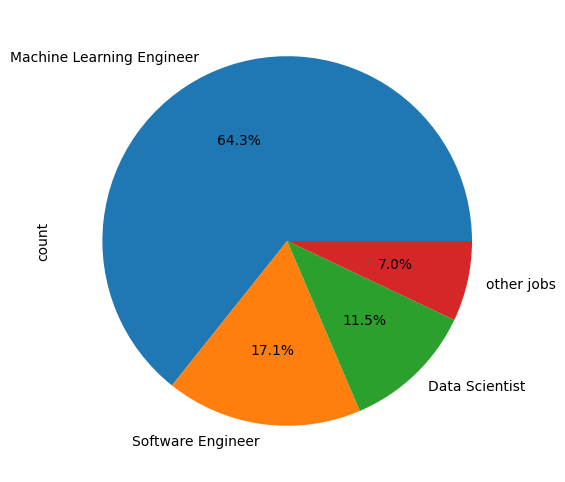

In [8]:
LABELS = ["Machine Learning Engineer","Software Engineer","Data Scientist"]

plt.figure(figsize=(10,6))
df['cleaned_jobs'].value_counts().plot(kind='pie',autopct="%1.1f%%")
plt.show()



In [9]:

df['Text'] = df['company_description'] + " ." + df["job_description_text"] + " ." + df['job_title']


def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = contractions.fix(text)
    text = text.translate(str.maketrans('','',string.punctuation)) # removing punctuations
    text = re.sub(r'[^a-zA-Z0-9\s]','',text)
    text = re.sub(r'\d+','',text)
    STOPWORDS = set(stopwords.words("english"))
    tokens = word_tokenize(text)
    cleaned_tokens = [word for word in tokens if word.lower() not in STOPWORDS]

    text=  " ".join(cleaned_tokens)
    return text


df['clean_text'] = df['Text'].apply(clean_text)
df['job_description_text'] = df['job_description_text'].apply(clean_text)
df['clean_text'].head(10)

0    upper hand leading provider fullsuite sports m...
1    built upon years mit research ikigai generativ...
2    adobe global leader digital media digital mark...
3    journey worlds trusted driver waymo driver imp...
4    adaptive learning company empowers educators f...
5    adobe global leader digital media digital mark...
6    walgreens included yous retail pharmacy segmen...
7    netflix one worlds leading entertainment servi...
8    netflix one worlds leading entertainment servi...
9    ailed platformdriven digital engineering enter...
Name: clean_text, dtype: object

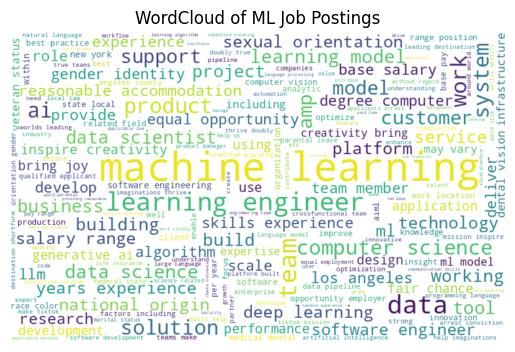

In [10]:
sample_txt = " ".join(i for i in df['clean_text'].astype(str))


wc = WordCloud(height=500,width=800,background_color="white").generate(sample_txt)
plt.imshow(wc,interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of ML Job Postings")
plt.show()



In [11]:
"""Most common words"""

most_common = nltk.FreqDist(TextBlob(sample_txt).words).most_common(200)
print('Top 200 most common words\n')
print(most_common)


Top 200 most common words

[('data', 4497), ('learning', 4473), ('machine', 3755), ('experience', 3410), ('work', 2546), ('team', 2358), ('ai', 2167), ('models', 1973), ('ml', 1658), ('including', 1556), ('company', 1525), ('engineer', 1509), ('engineering', 1434), ('solutions', 1406), ('business', 1386), ('software', 1370), ('skills', 1294), ('systems', 1251), ('new', 1230), ('across', 1200), ('us', 1194), ('science', 1192), ('development', 1164), ('role', 1153), ('teams', 1128), ('help', 1120), ('model', 1098), ('product', 1077), ('employees', 1060), ('technology', 1059), ('range', 1044), ('benefits', 1027), ('may', 1017), ('platform', 1011), ('computer', 998), ('build', 995), ('opportunity', 991), ('building', 972), ('one', 972), ('people', 941), ('years', 938), ('working', 879), ('time', 876), ('information', 874), ('technical', 874), ('make', 866), ('mission', 844), ('design', 822), ('best', 810), ('employment', 787), ('tools', 783), ('position', 772), ('services', 766), ('status'

In [12]:
""" Most Common Job Description Text By Job Title"""
df['text_job_title'] =  df['job_description_text'] + "[SEP]" + df['cleaned_jobs']
job_txt = " ".join(i for i in df['text_job_title'].astype(str))

most_frequent_words_by_job_title = nltk.FreqDist(TextBlob(job_txt).words).most_common(200)
print(most_frequent_words_by_job_title)


[('data', 4045), ('learning', 3777), ('experience', 3283), ('machine', 3089), ('work', 2358), ('team', 2136), ('models', 1885), ('ai', 1756), ('ml', 1603), ('including', 1452), ('engineering', 1350), ('skills', 1279), ('systems', 1166), ('science', 1149), ('business', 1131), ('role', 1130), ('company', 1099), ('software', 1096), ('development', 1088), ('model', 1065), ('solutions', 1036), ('new', 1022), ('product', 1013), ('benefits', 1006), ('may', 1002), ('range', 994), ('computer', 983), ('us', 963), ('opportunity', 933), ('teams', 923), ('employees', 914), ('years', 889), ('building', 862), ('across', 856), ('build', 840), ('SEP', 840), ('working', 834), ('technical', 826), ('one', 810), ('information', 786), ('design', 776), ('employment', 775), ('time', 772), ('help', 761), ('position', 761), ('engineer', 758), ('status', 745), ('paid', 738), ('amp', 728), ('tools', 727), ('python', 727), ('pay', 721), ('salary', 716), ('disability', 707), ('related', 705), ('platform', 688), ('E

In [13]:
nlp = spacy.load("en_core_web_sm")

"""POS Tagging"""

doc = nlp(sample_txt[:1000])

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

upper upper ADJ JJ amod xxxx True False
hand hand NOUN NN nmod xxxx True False
leading lead VERB VBG amod xxxx True False
provider provider NOUN NN nmod xxxx True False
fullsuite fullsuite NOUN NN compound xxxx True False
sports sport NOUN NNS compound xxxx True False
management management NOUN NN compound xxxx True False
software software NOUN NN nsubj xxxx True False
enable enable VERB VBP csubj xxxx True False
businesses business NOUN NNS nsubj xxxx True False
achieve achieve VERB VBP ccomp xxxx True False
less less ADJ JJR amod xxxx True True
sports sport NOUN NNS compound xxxx True False
facilities facility NOUN NNS compound xxxx True False
training training NOUN NN compound xxxx True False
academies academy NOUN NNS dobj xxxx True False
businesses business NOUN NNS nmod xxxx True False
small small ADJ JJ amod xxxx True False
enterprises enterprise NOUN NNS nsubj xxxx True False
large large ADJ JJ amod xxxx True False
franchises franchise NOUN NNS appos xxxx True False
use use VER

In [14]:
"""Word Similaritu"""

tokens = nlp(sample_txt[:500])


for token in tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

upper True 6.4926534 True
hand True 5.7751493 True
leading True 6.019238 True
provider True 5.356945 True
fullsuite True 6.2269993 True
sports True 6.663562 True
management True 5.522562 True
software True 5.2610025 True
enable True 5.8956165 True
businesses True 7.2145114 True
achieve True 6.4270825 True
less True 7.241632 True
sports True 6.693301 True
facilities True 5.632818 True
training True 7.096503 True
academies True 5.886093 True
businesses True 6.359603 True
small True 6.46949 True
enterprises True 6.110694 True
large True 6.621406 True
franchises True 6.0787787 True
use True 6.03348 True
upper True 6.6016808 True
hands True 6.3855834 True
integrated True 6.7269316 True
software True 6.7484274 True
payments True 5.7961373 True
platform True 5.4891915 True
operate True 5.672679 True
business True 5.8668475 True
efficiently True 8.124304 True
increase True 6.427832 True
customer True 6.53584 True
satisfaction True 5.413559 True
leverage True 5.1993666 True
realtime True 5.3971

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

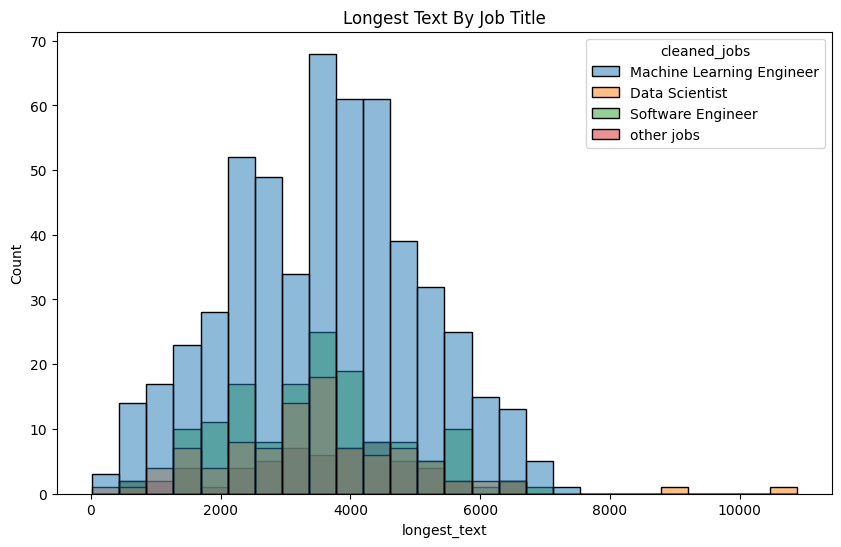

In [15]:
df['longest_text'] = df['text_job_title'].apply(len)

plt.figure(figsize=(10,6))
sns.histplot(x='longest_text',hue='cleaned_jobs',data=df)
plt.title('Longest Text By Job Title')
plt.show()





In [16]:

LABELS = ["Machine Learning Engineer","Software Engineer","Data Scientist","other jobs"]

In [17]:
le = LabelEncoder()


X = df['clean_text']
y = df['cleaned_jobs']
y=  le.fit_transform(y)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=42)

tfid = TfidfVectorizer()

X_train_tfid = tfid.fit_transform(X_train).toarray()
X_test_tfid = tfid.transform(X_test).toarray()


models = {
"multinomialnaivebayes":MultinomialNB(),
"logisticregression":LogisticRegression(),
"gausianNB":GaussianNB(),
"bernoulinaivebates":BernoulliNB(),
"randomforestclf":RandomForestClassifier(),
"baggingclassifier":BaggingClassifier(),
}



for model_name,model in models.items():
    model.fit(X_train_tfid,y_train)
    pred = model.predict(X_test_tfid)
    clf_rpt = classification_report(y_test,pred)
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test,pred,average="weighted")
    print(f'{model.__class__.__name__}; --Accuracy-- {acc*100:.2f}%; --Classification Report-- {clf_rpt}')
    print(f'{model.__class__.__name__}; --f1 score: {f1*100:.2f}%')


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MultinomialNB; --Accuracy-- 63.10%; --Classification Report--               precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.63      1.00      0.77       106
           2       0.00      0.00      0.00        29
           3       0.00      0.00      0.00        15

    accuracy                           0.63       168
   macro avg       0.16      0.25      0.19       168
weighted avg       0.40      0.63      0.49       168

MultinomialNB; --f1 score: 48.82%
LogisticRegression; --Accuracy-- 74.40%; --Classification Report--               precision    recall  f1-score   support

           0       0.77      0.56      0.65        18
           1       0.73      1.00      0.84       106
           2       1.00      0.28      0.43        29
           3       1.00      0.07      0.12        15

    accuracy                           0.74       168
   macro avg       0.87      0.47      0.51       168
weighted avg       0.8

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


BernoulliNB; --Accuracy-- 67.86%; --Classification Report--               precision    recall  f1-score   support

           0       1.00      0.11      0.20        18
           1       0.66      1.00      0.80       106
           2       1.00      0.21      0.34        29
           3       0.00      0.00      0.00        15

    accuracy                           0.68       168
   macro avg       0.67      0.33      0.33       168
weighted avg       0.70      0.68      0.58       168

BernoulliNB; --f1 score: 58.35%
RandomForestClassifier; --Accuracy-- 78.57%; --Classification Report--               precision    recall  f1-score   support

           0       0.93      0.72      0.81        18
           1       0.76      1.00      0.86       106
           2       0.92      0.38      0.54        29
           3       1.00      0.13      0.24        15

    accuracy                           0.79       168
   macro avg       0.90      0.56      0.61       168
weighted avg       0.8

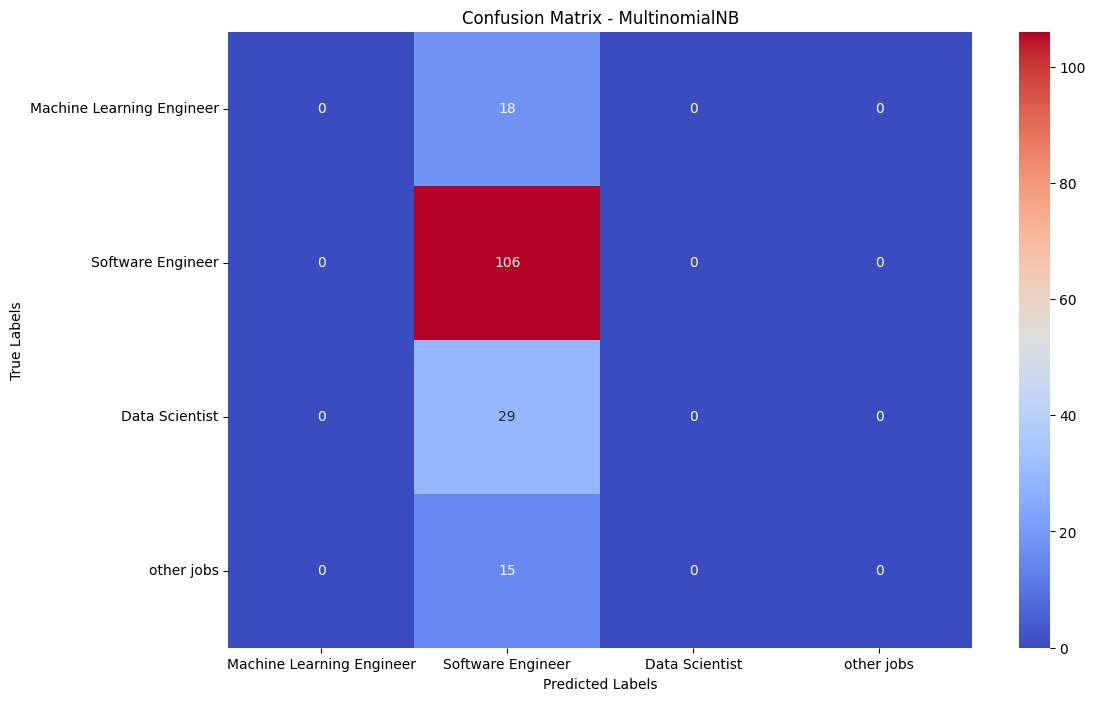

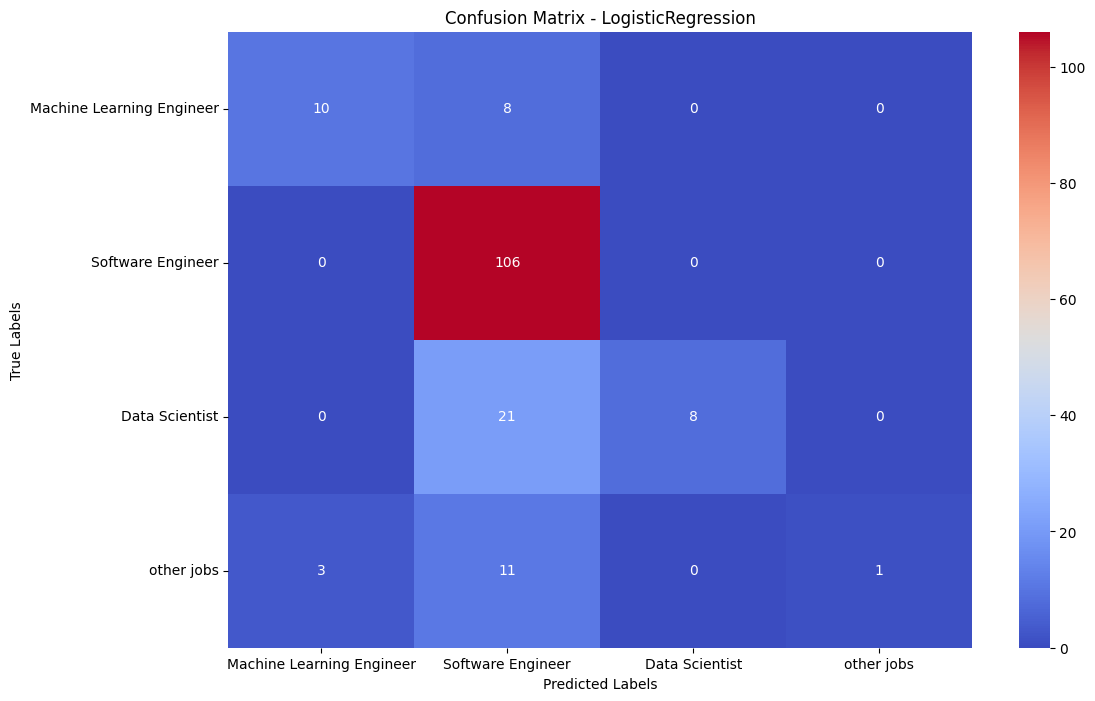

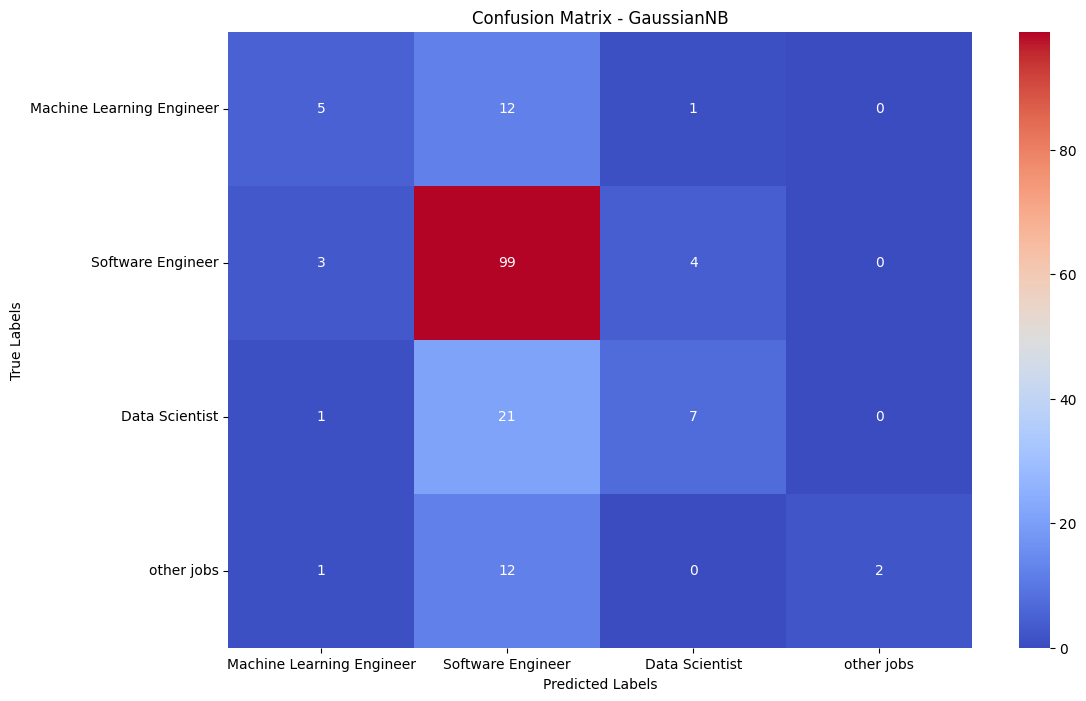

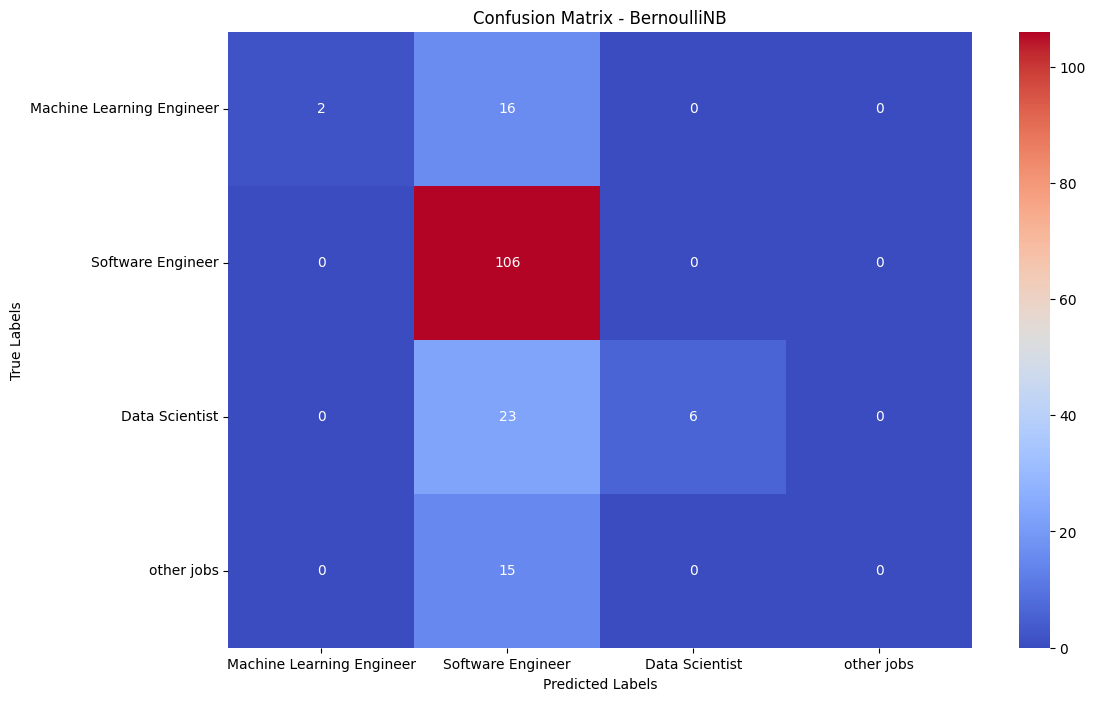

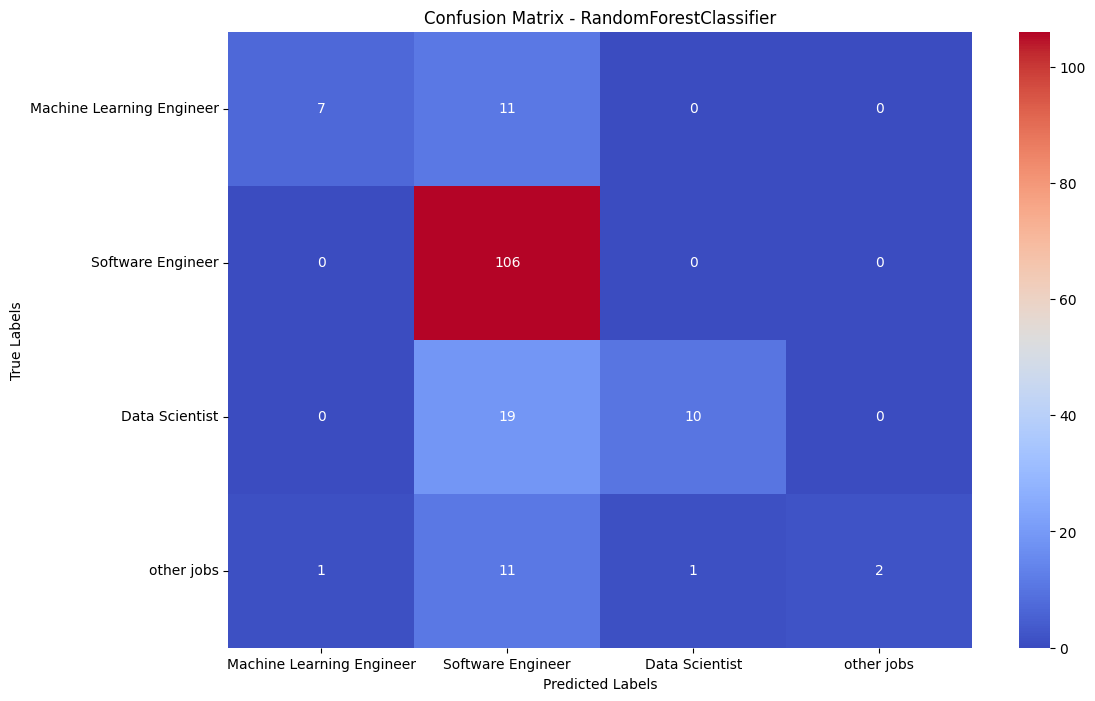

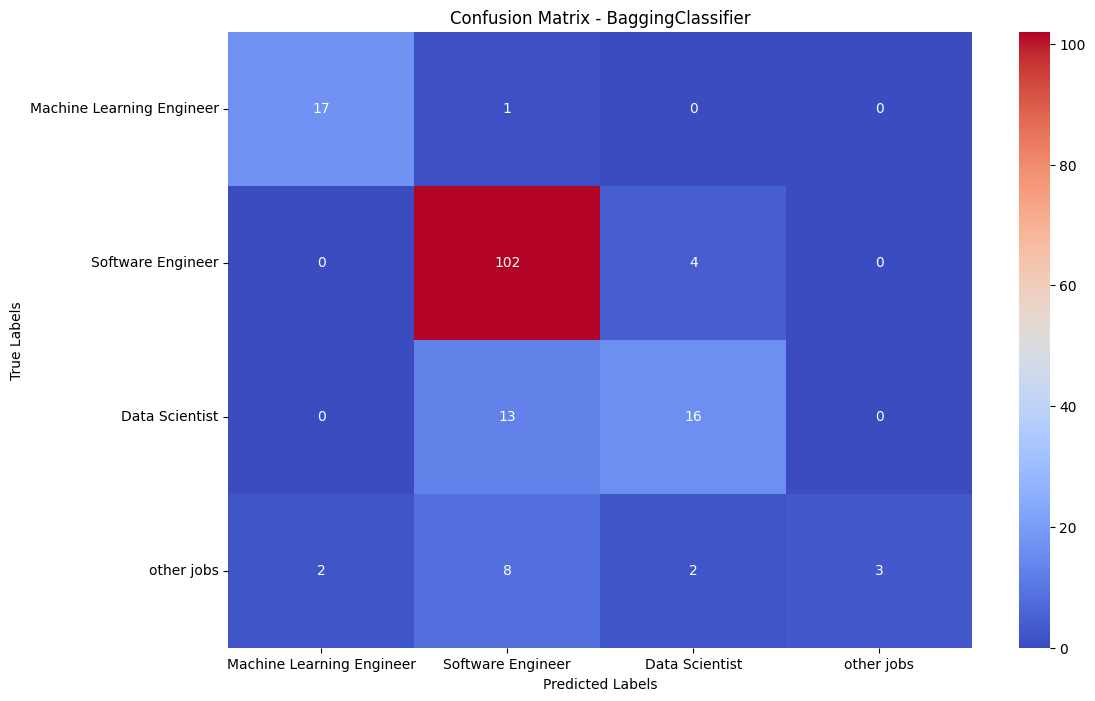

In [18]:
def plot_confusion_matrix(y_test, y_pred, model):
    conmap = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12,8))
    sns.heatmap(conmap, annot=True, fmt='d', cmap='coolwarm',xticklabels=LABELS,yticklabels=LABELS)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {model.__class__.__name__}')
    plt.show()


for model_name, model in models.items():
    model = model.fit(X_train_tfid, y_train)
    y_pred = model.predict(X_test_tfid)
    plot_confusion_matrix(y_test, y_pred, model)

In [19]:
df_bert = df.copy()

df_bert.head()
df_bert['Text'] = df_bert['cleaned_jobs'] + " ." + df_bert["job_description_text"] + " ." + df_bert['job_title']
df_bert['Text'] = df_bert['Text'].fillna("")
df_bert = df_bert[['Text','cleaned_jobs']]


df_bert.head(10)

df_bert['cleaned_jobs'].value_counts()

df_bert['Machine Learning Engineer'] = (df_bert['cleaned_jobs'] == "Machine Learning Engineer").astype(int)
df_bert['Software Engineer'] = (df_bert['cleaned_jobs'] == "Software Engineer").astype(int)
df_bert['Data Scientist'] = (df_bert['cleaned_jobs'] == "Data Scientist").astype(int)
df_bert['other jobs'] = (df_bert['cleaned_jobs'] == "other jobs").astype(int)
df_bert.drop("cleaned_jobs",axis=1,inplace=True)
df_bert.head(10)

,Text,Machine Learning Engineer,Software Engineer,Data Scientist,other jobs
0,Machine Learning Engineer .overviewupper hand ...,1,0,0,0
1,Machine Learning Engineer .company description...,1,0,0,0
2,Machine Learning Engineer .companychanging wor...,1,0,0,0
3,Machine Learning Engineer .waymo autonomous dr...,1,0,0,0
4,Machine Learning Engineer .job title machine l...,1,0,0,0
5,Machine Learning Engineer .companychanging wor...,1,0,0,0
6,Data Scientist .job summaryapplies advanced da...,0,0,1,0
7,Software Engineer .netflix one worlds leading ...,0,1,0,0
8,Machine Learning Engineer .netflix one worlds ...,1,0,0,0
9,Machine Learning Engineer .persistentwe truste...,1,0,0,0


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/tmp/ipykernel_19/3728212462.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_tokens)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to

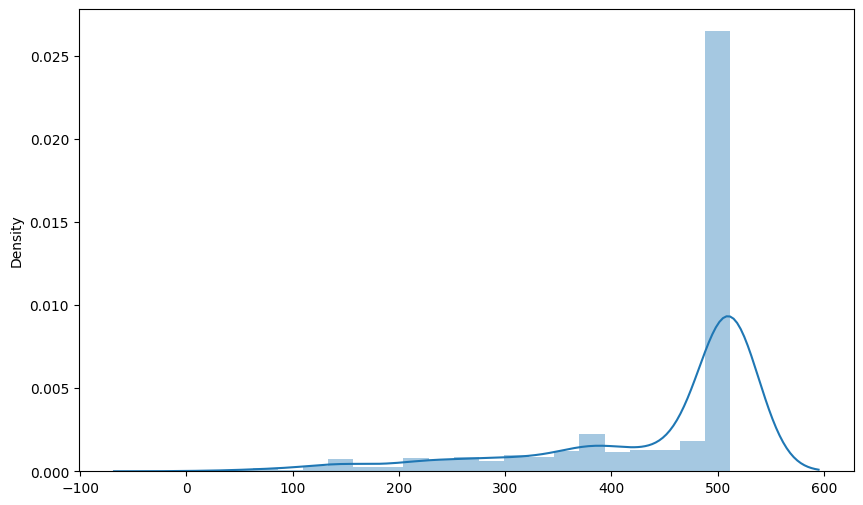

In [20]:
MODEL_NAME = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)


sample_tokens = []
for txt in df_bert['Text']:
    tokens = tokenizer.encode(txt,max_length=512)
    sample_tokens.append(len(tokens))


plt.figure(figsize=(10,6))
sns.distplot(sample_tokens)
plt.show()


In [21]:
MAX_LEN = 400



class Custom_Dataset(torch.utils.data.Dataset):
    def __init__(self,df_bert,labels,max_len,tokenizer):
        self.df_bert = df_bert
        self.Text = list(df_bert['Text'])
        self.targets = self.df_bert[labels].values
        self.max_len = max_len
        self.tokenizer=  tokenizer


    def __len__(self):
        return len(self.Text)


    def __getitem__(self, idx):
        Text = str(self.Text[idx])
        Text = " ".join(Text.split())

        encoder = self.tokenizer.encode_plus(
            Text,
            None,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            add_special_tokens=True,
            return_tensors='pt',
            )

        return {
            "Text":Text,
            "input_ids":encoder['input_ids'].flatten(),
            "attention_mask":encoder['attention_mask'].flatten(),
            "token_type_ids":encoder['token_type_ids'].flatten(),
            "targets":torch.FloatTensor(self.targets[idx])
            }


df_train,df_test = train_test_split(df_bert,test_size=.20,random_state=42)
df_val,df_test = train_test_split(df_test,test_size=.50,random_state=42)


labels = list(df_bert.columns)
labels = labels[1:]

train_dataset = Custom_Dataset(df_train,labels,max_len=MAX_LEN,tokenizer=tokenizer)
test_dataset = Custom_Dataset(df_test, labels, max_len=MAX_LEN, tokenizer=tokenizer)
val_dataset = Custom_Dataset(df_val, labels, max_len=MAX_LEN, tokenizer=tokenizer)

TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8
VAL_BATCH_SIZE = 8
learning_rate = 1e-5
epochs = 4



train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=TRAIN_BATCH_SIZE,num_workers=4)
test_dataloader=  torch.utils.data.DataLoader(test_dataset,batch_size=TEST_BATCH_SIZE,num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=VAL_BATCH_SIZE,num_workers=4)





In [22]:
class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        self.bert_model = BertModel.from_pretrained(MODEL_NAME, return_dict=True)
        self.dropout = torch.nn.Dropout(0.1)
        self.linear = torch.nn.Linear(768, 4)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output




model = BertClassifier()
model.to(device)




def loss_fn(outputs,targets):
    return nn.BCEWithLogitsLoss()(outputs,targets)



optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate)



def train_model(train_dataloader, model, optimizer):
    model.train()
    losses = []
    correct_predictions = 0
    num_samples = 0
    loop = tq.tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=True)
    for batch_idx, data in loop:
        input_ids = data['input_ids'].to(device, dtype = torch.long)
        attention_mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)


        outputs = model(input_ids, attention_mask,token_type_ids)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        _, preds = torch.max(outputs, dim=1)
        _, targ = torch.max(targets, dim=1)
        num_samples += len(targ)
        correct_predictions += torch.sum(preds == targ)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()


    return model, float(correct_predictions)/num_samples, np.mean(losses)



def eval_model(val_dataloader, model, optimizer):
    model.eval()
    losses = []
    correct_predictions = 0
    num_samples = 0


    with torch.no_grad():
        for batch_idx, data in enumerate(val_dataloader, 0):
            input_ids = data['input_ids'].to(device, dtype = torch.long)
            attention_mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(input_ids, attention_mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())


            _, preds = torch.max(outputs, dim=1)
            _, targ = torch.max(targets, dim=1)
            num_samples += len(targ)
            correct_predictions += torch.sum(preds == targ)

    return float(correct_predictions)/num_samples, np.mean(losses)






for epoch in range(1, epochs+1):
    print(f'Epoch {epoch}/{epochs}')
    model, train_acc, train_loss = train_model(train_dataloader, model, optimizer)
    print(f'Training Accuracy: {train_acc*100:.2f}%; --Training Loss: {train_loss:.4f}')
    val_acc, val_loss = eval_model(val_dataloader, model, optimizer)

    print(f'val_acc: {val_acc*100:.2f}%; val_loss: {val_loss:.4f}')


test_acc,test_loss = eval_model(test_dataloader, model, optimizer)
print(f'testing accuracy: {test_acc*100:.2f}%')
print(f'testing loss: {test_loss:.4f}')


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/4


  0%|          | 0/84 [00:00<?, ?it/s]

Training Accuracy: 60.27%; --Training Loss: 0.4743
val_acc: 65.48%; val_loss: 0.4228
Epoch 2/4


  0%|          | 0/84 [00:00<?, ?it/s]

Training Accuracy: 75.30%; --Training Loss: 0.3283
val_acc: 79.76%; val_loss: 0.2276
Epoch 3/4


  0%|          | 0/84 [00:00<?, ?it/s]

Training Accuracy: 88.99%; --Training Loss: 0.1784
val_acc: 97.62%; val_loss: 0.1101
Epoch 4/4


  0%|          | 0/84 [00:00<?, ?it/s]

Training Accuracy: 99.85%; --Training Loss: 0.0753
val_acc: 100.00%; val_loss: 0.0445
testing accuracy: 100.00%
testing loss: 0.0481


In [23]:
df_t5 = df.copy()
df_t5 = df_t5[["job_description_text","company_description"]]

df_t5



,job_description_text,company_description
0,overviewupper hand embarking exciting journey ...,Upper Hand is the leading provider of full-sui...
1,company descriptionthe ikigai platform unlocks...,"Built upon years of MIT research, Ikigai is a ..."
2,companychanging world digital experiences adob...,Adobe is the global leader in digital media an...
3,waymo autonomous driving technology company mi...,On the journey to be the world's most trusted ...
4,job title machine learning engineerlocation re...,We are an adaptive learning company that empow...
...,...,...
992,reality labs meta building products make easie...,Meta's mission is to build the future of human...
993,midsized management consulting automation data...,The Lab is a management consulting firm that h...
994,fanduelfanduel group premier mobile gaming com...,FanDuel Group is an innovative sports-tech ent...
995,teamtapestry xs moonshot electric grid team so...,We create breakthrough technologies to help so...


In [24]:
df_t5.drop_duplicates(inplace=True)

In [25]:
df_t5['job_description_text'] = "Summarize: " + df_t5['job_description_text']
df_t5.head(10)

,job_description_text,company_description
0,Summarize: overviewupper hand embarking exciti...,Upper Hand is the leading provider of full-sui...
1,Summarize: company descriptionthe ikigai platf...,"Built upon years of MIT research, Ikigai is a ..."
2,Summarize: companychanging world digital exper...,Adobe is the global leader in digital media an...
3,Summarize: waymo autonomous driving technology...,On the journey to be the world's most trusted ...
4,Summarize: job title machine learning engineer...,We are an adaptive learning company that empow...
5,Summarize: companychanging world digital exper...,Adobe is the global leader in digital media an...
6,Summarize: job summaryapplies advanced data an...,Walgreens (www.walgreens.com) is included in t...
7,Summarize: netflix one worlds leading entertai...,Netflix is one of the world's leading entertai...
8,Summarize: netflix one worlds leading entertai...,Netflix is one of the world's leading entertai...
9,Summarize: persistentwe trusted digital engine...,"We are an AI-led, platform-driven Digital Engi..."


In [26]:
"""The ole rich table"""

console = Console(record=True)

def display_df(df_t5):
    console = Console()
    table = Table(
        Column("source_text",justify="center"),
        Column("target_text",justify="center"),
        title="sample_data",
        pad_edge=False,
        box=box.ASCII
    )
    
    
    
    for i,row in enumerate(df_t5.values.tolist()):
        table.add_row(row[0],row[1])
        
    console.print(table)



training_logger = Table(
    Column("Epoch", justify="center"),
    Column("Steps", justify="center"),
    Column("Loss", justify="center"),
    title="Training Status",
    pad_edge=False,
    box=box.ASCII,
)



In [27]:
class Custom_Dataset(torch.utils.data.Dataset):
    def __init__(self,dataframe,tokenizer,source_len,target_len,source_text,target_text):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_len = source_len
        self.summ_len = target_len
        self.source_text = self.data[source_text]
        self.target_text = self.data[target_text]
        
        
    def __len__(self):
        return len(self.target_text)
    
    def __getitem__(self,index):
        target_text = str(self.target_text[index])
        source_text = str(self.source_text[index])
        

        
        source = self.tokenizer.batch_encode_plus([source_text], max_length= self.source_len, truncation=True, padding="max_length", return_tensors='pt')
        target = self.tokenizer.batch_encode_plus([target_text], max_length= self.summ_len, truncation=True, padding="max_length", return_tensors='pt')
        

        
        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_ids = target['input_ids'].squeeze()
        
        return {
            "source_ids":source_ids.to(device,dtype=torch.long),
            "source_mask":source_mask.to(device,dtype=torch.long),
            "target_ids":target_ids.to(device,dtype=torch.long),
            "target_ids_y":target_ids.to(device,dtype=torch.long)
        }

In [28]:
def train(epoch, tokenizer, model, device, loader, optimizer):


  model.train()
  for _,d in enumerate(loader, 0):
    y = d['target_ids'].to(device, dtype = torch.long)
    y_ids = y[:, :-1].contiguous()
    lm_labels = y[:, 1:].clone().detach()
    lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
    ids = d['source_ids'].to(device, dtype = torch.long)
    mask = d['source_mask'].to(device, dtype = torch.long)

    outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, labels=lm_labels)
    loss = outputs[0]



    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [29]:
def validate(epoch, tokenizer, model, device, loader):

  model.eval()
  predictions = []
  actuals = []
  with torch.no_grad():
      for _, d in enumerate(loader, 0):
          y = d['target_ids'].to(device, dtype = torch.long)
          ids = d['source_ids'].to(device, dtype = torch.long)
          mask = d['source_mask'].to(device, dtype = torch.long)

          generated_ids = model.generate(
              input_ids = ids,
              attention_mask = mask, 
              max_length=128, 
              num_beams=2,
              repetition_penalty=2.5, 
              length_penalty=1.0, 
              early_stopping=True
              )
          preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
          target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
          if _%10==0:
            print(f'Completed {_}')

          predictions.extend(preds)
          actuals.extend(target)
  return predictions, actuals

In [30]:
def T5Trainer(
    dataframe, source_text, target_text, model_params, output_dir="/kaggle/working/"
):







    torch.manual_seed(model_params["SEED"]) 
    np.random.seed(model_params["SEED"])
    torch.backends.cudnn.deterministic = True


    console.log(f"""[Model]: Loading {model_params["MODEL"]}...\n""")


    tokenizer = T5Tokenizer.from_pretrained(model_params["MODEL"])

    model = T5ForConditionalGeneration.from_pretrained(model_params["MODEL"])
    model = model.to(device)


    console.log(f"[Data]: Reading data...\n")


    dataframe = dataframe[[source_text, target_text]]
    display_df(dataframe.head(10))



    train_size = 0.8
    train_dataset = dataframe.sample(frac=train_size, random_state=model_params["SEED"])
    val_dataset = dataframe.drop(train_dataset.index).reset_index(drop=True)
    train_dataset = train_dataset.reset_index(drop=True)

    console.print(f"FULL Dataset: {dataframe.shape}")
    console.print(f"TRAIN Dataset: {train_dataset.shape}")
    console.print(f"TEST Dataset: {val_dataset.shape}\n")


    training_set = Custom_Dataset(
        train_dataset,
        tokenizer,
        model_params["MAX_SOURCE_TEXT_LENGTH"],
        model_params["MAX_TARGET_TEXT_LENGTH"],
        source_text,
        target_text,
    )
    val_set = Custom_Dataset(
        val_dataset,
        tokenizer,
        model_params["MAX_SOURCE_TEXT_LENGTH"],
        model_params["MAX_TARGET_TEXT_LENGTH"],
        source_text,
        target_text,
    )

    train_params = {
        "batch_size": model_params["TRAIN_BATCH_SIZE"],
        "shuffle": True,
        "num_workers": 0,
    }

    val_params = {
        "batch_size": model_params["VALID_BATCH_SIZE"],
        "shuffle": False,
        "num_workers": 0,
    }

    training_loader = DataLoader(training_set, **train_params)
    val_loader = DataLoader(val_set, **val_params)

    optimizer = torch.optim.Adam(
        params=model.parameters(), lr=model_params["LEARNING_RATE"]
    )

    console.log(f"[Initiating Fine Tuning]...\n")

    for epoch in range(model_params["TRAIN_EPOCHS"]):
        train(epoch, tokenizer, model, device, training_loader, optimizer)

    console.log(f"[Saving Model]...\n")
    path = os.path.join(output_dir, "model_files")
    model.save_pretrained(path)
    tokenizer.save_pretrained(path)

    console.log(f"[Initiating Validation]...\n")
    for epoch in range(model_params["VAL_EPOCHS"]):
        predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
        final_df = pd.DataFrame({"Generated Text": predictions, "Actual Text": actuals})
        final_df.to_csv(os.path.join(output_dir, "predictions.csv"))

    console.save_text(os.path.join(output_dir, "logs.txt"))

    console.log(f"[Validation Completed.]\n")

    
    return final_df

In [31]:
model_params={
    "MODEL":"t5-base",
    "TRAIN_BATCH_SIZE":8,
    "VALID_BATCH_SIZE":8,
    "TRAIN_EPOCHS":2,
    "VAL_EPOCHS":1,
    "LEARNING_RATE":1e-4,
    "MAX_SOURCE_TEXT_LENGTH":128,
    "MAX_TARGET_TEXT_LENGTH":50,
    "SEED": 42

}

In [32]:
T5Trainer(dataframe=df_t5[:500], source_text="job_description_text", target_text="company_description", model_params=model_params, output_dir="outputs")

[18:19:39] [Model]: Loading t5-base...                                                              ]8;id=65612;file:///tmp/ipykernel_19/598340825.py\598340825.py]8;;\:]8;id=834505;file:///tmp/ipykernel_19/598340825.py#16\16]8;;\
                                                                                                                   

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

[18:19:44] [Data]: Reading data...                                                                  ]8;id=637383;file:///tmp/ipykernel_19/598340825.py\598340825.py]8;;\:]8;id=6946;file:///tmp/ipykernel_19/598340825.py#25\25]8;;\
                                                                                                                   

                                                    sample_data                                                    
+-----------------------------------------------------------------------------------------------------------------+
|                      source_text                       |                       target_text                      |
|--------------------------------------------------------+--------------------------------------------------------|
|   Summarize: overviewupper hand embarking exciting     | Upper Hand is the leading provider of full-suite sports|
|journey harness power machine learning data science ai  |  management software that enable businesses to achieve |
| enhance sports training management looking energetic   |                 more while doing less.                 |
|talented machine learning engineer data scientist join  |                                                        |
| ai data science team part team instrumental building   | Sports facilities, training academies, and businesses -|
| deploying machine learning models ensuring align real  | from small enterprises to large franchises - use Upper |
|business use cases also leverage expertise data science |   Hand’s integrated software and payments platform to  |
|     develop datadriven insights optimize aidriven      |    operate their business more efficiently, increase   |
|   initiatives role ideal someone thrives fastpaced     | customer satisfaction, and leverage real-time data for |
|   collaborative environment loves solving realworld    |                 better decision-making.                |
|    problems machine learning passion communication     |                                                        |
|   presenting solutionswhat dobuild deploy maintain     |  Its product suite includes features to manage client  |
|  scalable machine learning models solve key business   |    booking and registration, memberships, staff and    |
|   challengeswork closely external clients internal     | facility scheduling, retail, video analysis, and more. |
|crossfunctional teams translate business needs machine  |  For more information on how Upper Hand is reinventing |
|    learning solutionscollaborate model deployment      |  the way business is done in sports and fitness, visit |
| monitoring ensuring performance accuracy timedevelop   |                     upperhand.com.                     |
|  data pipelines workflows ensure data accessibility    |                                                        |
|  readiness model traininguse data science techniques   |                                                        |
|  extract insights improve predictions drive business   |                                                        |
|     decisionmakingcreate impactful presentations       |                                                        |
|  communicate model results recommendations technical   |                                                        |
| nontechnical audiencessupport continuous improvement   |                                                        |
| researching integrating latest machine learning tools  |                                                        |
|algorithms frameworkscollaborate product managers data  |                                                        |
|engineers stakeholders align machine learning solutions |                                                        |
|strategic goalswho areyoure passionate machine learning |                                                        |
|data science using technology solve complex problemsyou |                                                        |
|   experience building deploying monitoring machine     |                                                        |
|   learning models realworld applicationsyou possess    |                                                        |
|strong analytical skills solid foundation data science 

FULL Dataset: (500, 2)

TRAIN Dataset: (400, 2)

TEST Dataset: (100, 2)

           [Initiating Fine Tuning]...                                                              ]8;id=831180;file:///tmp/ipykernel_19/598340825.py\598340825.py]8;;\:]8;id=64645;file:///tmp/ipykernel_19/598340825.py#79\79]8;;\
                                                                                                                   

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


[18:20:25] [Saving Model]...                                                                        ]8;id=774707;file:///tmp/ipykernel_19/598340825.py\598340825.py]8;;\:]8;id=993579;file:///tmp/ipykernel_19/598340825.py#84\84]8;;\
                                                                                                                   

[18:20:27] [Initiating Validation]...                                                               ]8;id=13182;file:///tmp/ipykernel_19/598340825.py\598340825.py]8;;\:]8;id=493182;file:///tmp/ipykernel_19/598340825.py#89\89]8;;\
                                                                                                                   

Completed 0
Completed 10


[18:20:59] [Validation Completed.]                                                                  ]8;id=954581;file:///tmp/ipykernel_19/598340825.py\598340825.py]8;;\:]8;id=810502;file:///tmp/ipykernel_19/598340825.py#97\97]8;;\
                                                                                                                   

,Generated Text,Actual Text
0,ikigai unlocks power generative ai tabular dat...,"Built upon years of MIT research, Ikigai is a ..."
1,adobes is changing the world digital experienc...,Adobe is the global leader in digital media an...
2,is the world's leading electric load forecasti...,National Grid lies at the heart of a transform...
3,Adobes is changing the way we interact with cu...,Adobe is the global leader in digital media an...
4,is a dynamic team of data scientists who are e...,Intuit is a global technology platform that he...
...,...,...
95,ai systems designing robust ml infrastructure ...,Plus is a global AI-first autonomous trucking ...
96,: tiktok is the world's leading destination fo...,TikTok is the world's leading destination for ...
97,a data scientist is to build predictive models...,InterEx’s vision is to revolutionise the techn...
98,: tiktok is the world's leading destination fo...,TikTok is the world's leading destination for ...
